## Lead Scoring with Logistic Regression
##### Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads

In [963]:
import warnings
warnings.filterwarnings('ignore')

In [964]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
pd.set_option('display.max_columns',500)

## [Step 1. Reading and Understanding the Data](#step1)

## [Step 2.Data Cleaning and EDA](#step2)
[2.1 Missing value check](#step2.1)<br>
[2.2 Cleaning and Visualizing categorical variables](#step2.2)<br>
[2.3 Cleaning and Visualizing numerical variables](#step2.3)<br>
[2.4 Outlier Treatment](#step2.4)<br>
[2.5 Check for duplicates](#step2.5)<br>
[2.6 Check for data type conversion](#step2.6)<br>

## [Step 3. Preprocessing and Data Preparation](#step3)
[3.1 Categorizing variables](#step3.1)<br>
[3.2 Creating dummy variables](#step3.2)<br>
[3.3 Train test split](#step3.3)<br>
[3.4 Scaling data](#step3.4)<br>

## [Step 4. Model Building](#Step4)



The above steps will be covered to build the model. 

## Step 1. Reading and Understanding the Data<a id='step1'></a>

In [965]:
lead_data = pd.read_csv('Leads.csv')
lead_data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [966]:
lead_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

In [967]:
lead_data.shape

(9240, 37)

In [968]:
lead_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Lead Number,9240.0,617188.435606,23405.995698,579533.0,596484.5,615479.0,637387.25,660737.0
Converted,9240.0,0.385390,0.486714,0.0,0.0,0.0,1.00,1.0
TotalVisits,9103.0,3.445238,4.854853,0.0,1.0,3.0,5.00,251.0
Total Time Spent on Website,9240.0,487.698268,548.021466,0.0,12.0,248.0,936.00,2272.0
Page Views Per Visit,9103.0,2.362820,2.161418,0.0,1.0,2.0,3.00,55.0
Asymmetrique Activity Score,5022.0,14.306252,1.386694,7.0,14.0,14.0,15.00,18.0
Asymmetrique Profile Score,5022.0,16.344883,1.811395,11.0,15.0,16.0,18.00,20.0


Out of 37 columns,the bottom 5 from the above list are numeric columns

In [969]:
#Checking data imbalance
lead_data['Converted'].mean()

0.3853896103896104

#### Only 38% of the leads were converted

In [970]:
#lead_data.columns

In [971]:
#renaming lengthy names of columns
lead_data = lead_data.rename({'Total Time Spent on Website':'Website Time','What is your current occupation': 'Occupation','What matters most to you in choosing a course':'Reason','A free copy of Mastering The Interview':'Free copy required'}, axis=1)
lead_data.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Website Time', 'Page Views Per Visit', 'Last Activity', 'Country',
       'Specialization', 'How did you hear about X Education', 'Occupation',
       'Reason', 'Search', 'Magazine', 'Newspaper Article',
       'X Education Forums', 'Newspaper', 'Digital Advertisement',
       'Through Recommendations', 'Receive More Updates About Our Courses',
       'Tags', 'Lead Quality', 'Update me on Supply Chain Content',
       'Get updates on DM Content', 'Lead Profile', 'City',
       'Asymmetrique Activity Index', 'Asymmetrique Profile Index',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque', 'Free copy required',
       'Last Notable Activity'],
      dtype='object')

## Step 2.Data Cleaning and EDA<a id='step2'></a>

#### 2.1 Missing value check<a id=step2.1></a>


In [972]:
# sum it up to check how many rows have all missing values
lead_data.isnull().all(axis=1).sum()

0

In [973]:
len(lead_data[lead_data.isnull().sum(axis=1)>5].index)


2923

In [974]:
# % of the missing values (column-wise)
round(100*(lead_data.isnull().sum()/len(lead_data.index)), 2)


Prospect ID                                  0.00
Lead Number                                  0.00
Lead Origin                                  0.00
Lead Source                                  0.39
Do Not Email                                 0.00
Do Not Call                                  0.00
Converted                                    0.00
TotalVisits                                  1.48
Website Time                                 0.00
Page Views Per Visit                         1.48
Last Activity                                1.11
Country                                     26.63
Specialization                              15.56
How did you hear about X Education          23.89
Occupation                                  29.11
Reason                                      29.32
Search                                       0.00
Magazine                                     0.00
Newspaper Article                            0.00
X Education Forums                           0.00


#### We do see lots of missing values and most of columns have greater than 20% missing values. Lets divide the columns into categorical and numerical and handle them one by one.

#### 2.2 Cleaning and Visualizing categorical variables<a id='step2.2'></a>

In [975]:
## Dropping columns having > 45% missing values
lead_data.drop(['Asymmetrique Activity Index','Asymmetrique Profile Index','Asymmetrique Activity Score','Asymmetrique Profile Score','Lead Quality'],axis=1,inplace=True)

In [976]:
lead_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 32 columns):
Prospect ID                                 9240 non-null object
Lead Number                                 9240 non-null int64
Lead Origin                                 9240 non-null object
Lead Source                                 9204 non-null object
Do Not Email                                9240 non-null object
Do Not Call                                 9240 non-null object
Converted                                   9240 non-null int64
TotalVisits                                 9103 non-null float64
Website Time                                9240 non-null int64
Page Views Per Visit                        9103 non-null float64
Last Activity                               9137 non-null object
Country                                     6779 non-null object
Specialization                              7802 non-null object
How did you hear about X Education          7033 

In [977]:
cat_cols = ['Lead Origin', 'Lead Source','Do Not Email', 'Do Not Call', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'Occupation',
       'Reason', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City','I agree to pay the amount through cheque',
       'Free copy required', 'Last Notable Activity']

In [978]:
len(cat_cols)

26

In [979]:
#Function to check total counts, skewness and importance of a categorical column based on conversion rate. 
def check_count_conversion_rate(X):
    #checking counts of col
    col_counts = pd.DataFrame(lead_data[X].value_counts()).reset_index()
    col_counts.columns = [X,'Counts']
    col_counts['Total%'] = col_counts['Counts']/len(lead_data.index)
    #checking conversion rate by col
    groupby_col = pd.DataFrame(lead_data.groupby(X)['Converted'].mean()).reset_index()

    col_counts_percentage = col_counts.merge(groupby_col,how='inner',on=X)
    return col_counts_percentage

In [980]:
def check_2_col_count_conversion_rate(X):
    col_counts = pd.DataFrame(lead_data.groupby(X)[X[1]].count())
    col_counts.columns = ['Counts']
    col_counts.reset_index()
     #checking conversion rate by col
    groupby_col = pd.DataFrame(lead_data.groupby(X)['Converted'].mean()).reset_index()
    groupby_col
    col_counts_percentage = pd.merge(col_counts, groupby_col,  how='left', left_on=X, right_on = X)
    return col_counts_percentage

In [981]:
round(100*(lead_data[cat_cols].isnull().sum()/len(lead_data.index)), 2)


Lead Origin                                  0.00
Lead Source                                  0.39
Do Not Email                                 0.00
Do Not Call                                  0.00
Last Activity                                1.11
Country                                     26.63
Specialization                              15.56
How did you hear about X Education          23.89
Occupation                                  29.11
Reason                                      29.32
Search                                       0.00
Magazine                                     0.00
Newspaper Article                            0.00
X Education Forums                           0.00
Newspaper                                    0.00
Digital Advertisement                        0.00
Through Recommendations                      0.00
Receive More Updates About Our Courses       0.00
Tags                                        36.29
Update me on Supply Chain Content            0.00


The value of `Select` in categorical columns are treated as null.Therefore, will convert `Select` value to `NaN` before checking the actual missing value percentage of a particular column.

#### Checking skewed categorical Variable

In [982]:
def check_skewness(X):
    count_of_values = lead_data[X].value_counts().values
    count_of_values = count_of_values/len(lead_data)
    col_of_values = list(lead_data[X].value_counts().index)
    dict_data = {}
    for i in range(0,len(col_of_values)):
        dict_data[col_of_values[i]] = count_of_values[i]
    df = pd.DataFrame(data=dict_data,index=[X])
    return df

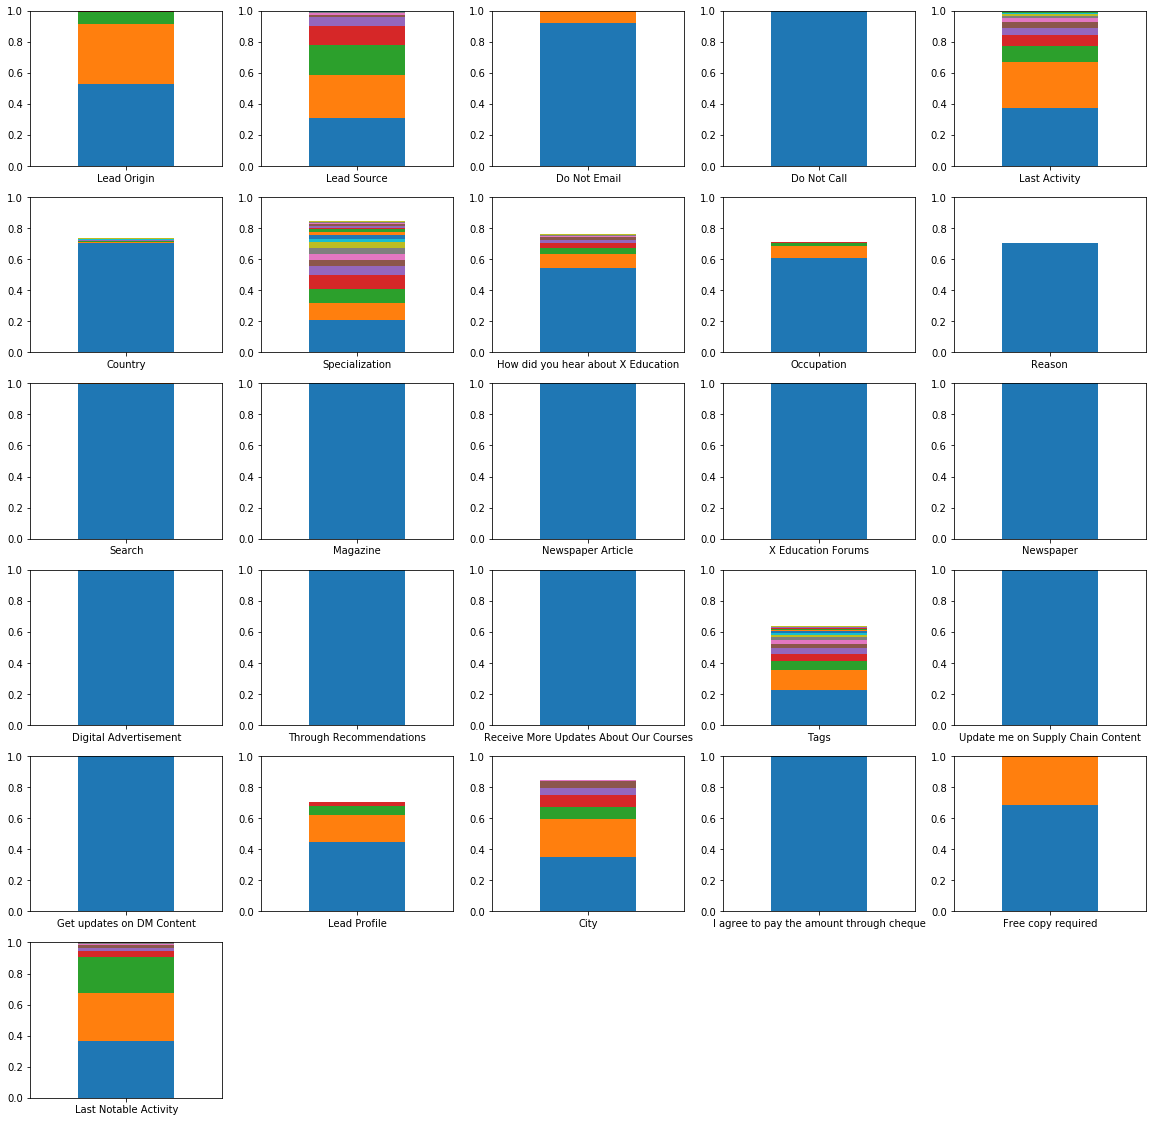

In [983]:
plt.figure(figsize=[20,20])
skewness = []
for i in range(0,len(cat_cols)):
    ax = plt.subplot(6,5,i+1)
    skewness.append(check_skewness(cat_cols[i]))
    skewness[i].plot(kind='bar',stacked=True,ax = ax)
    ax.legend().set_visible(False)
    plt.xticks(rotation=0)
    ax.set_ylim([0.0,1.0])
plt.show()

#check_skewness(cat_cols[4]).plot.bar(stacked=True)

#### Inference:
- We see lot of columns that are skewed and has only one value more than 90% of the time
- The reason some bars are not 100% complete is because of the presence of null values.
- Its better to delete highly skewed columns as they will not be helpfull in predictions.

In [984]:
#Deleting cols where 90% of the values are same
skewed_cols = ['Do Not Email', 'Do Not Call',
       'Reason', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'I agree to pay the amount through cheque']
lead_data.drop(skewed_cols,axis=1,inplace=True)
lead_data.shape

(9240, 18)

In [985]:
for i in skewed_cols:
    cat_cols.remove(i)
cat_cols

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Country',
 'Specialization',
 'How did you hear about X Education',
 'Occupation',
 'Tags',
 'Lead Profile',
 'City',
 'Free copy required',
 'Last Notable Activity']

In [986]:
round(100*(lead_data[cat_cols].isnull().sum()/len(lead_data.index)), 2)


Lead Origin                            0.00
Lead Source                            0.39
Last Activity                          1.11
Country                               26.63
Specialization                        15.56
How did you hear about X Education    23.89
Occupation                            29.11
Tags                                  36.29
Lead Profile                          29.32
City                                  15.37
Free copy required                     0.00
Last Notable Activity                  0.00
dtype: float64

In [987]:
#deleting cols where missing % is greater than 45%
# missing_45 = ['Lead Quality','Asymmetrique Activity Index','Asymmetrique Profile Index']
# lead_data.drop(missing_45,axis=1,inplace=True)
# print("final shape = {}".format(lead_data.shape))
# for i in missing_45:
#     cat_cols.remove(i)
# cat_cols

In [988]:
round(100*(lead_data[cat_cols].isnull().sum()/len(lead_data.index)), 2)


Lead Origin                            0.00
Lead Source                            0.39
Last Activity                          1.11
Country                               26.63
Specialization                        15.56
How did you hear about X Education    23.89
Occupation                            29.11
Tags                                  36.29
Lead Profile                          29.32
City                                  15.37
Free copy required                     0.00
Last Notable Activity                  0.00
dtype: float64

In [989]:
100*(len(lead_data[lead_data[cat_cols].isnull().sum(axis=1)>6].index)/len(lead_data.index))
len(lead_data[lead_data[cat_cols].isnull().sum(axis=1)>4].index)


1437

#### Handling Lead Source

In [990]:
#checking number of missing values
lead_data['Lead Source'].isnull().sum()

36

In [991]:
check_count_conversion_rate('Lead Source').sort_values(by='Total%',ascending = False)

,Lead Source,Counts,Total%,Converted
0,Google,2868,0.310390,0.399930
1,Direct Traffic,2543,0.275216,0.321667
2,Olark Chat,1755,0.189935,0.255271
3,Organic Search,1154,0.124892,0.377816
4,Reference,534,0.057792,0.917603
5,Welingak Website,142,0.015368,0.985915
6,Referral Sites,125,0.013528,0.248000
7,Facebook,55,0.005952,0.236364
8,bing,6,0.000649,0.166667
9,google,5,0.000541,0.000000


#### Inferences:
- Google is written as google in 5 values.
- There are total 21 different values for the column
- There are few of them which were used only once. Will to combine them into others later.

In [992]:
#google to Google
lead_data.loc[(lead_data['Lead Source'] == 'google'),['Lead Source']] = 'Google'
lead_data['Lead Source'].value_counts()


Google               2873
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
Click2call              4
Social Media            2
Live Chat               2
Press_Release           2
blog                    1
welearnblog_Home        1
Pay per Click Ads       1
WeLearn                 1
NC_EDM                  1
testone                 1
youtubechannel          1
Name: Lead Source, dtype: int64

In [993]:
check_count_conversion_rate('Lead Source').sort_values(by='Converted',ascending = False)

,Lead Source,Counts,Total%,Converted
17,NC_EDM,1,0.000108,1.000000
16,WeLearn,1,0.000108,1.000000
11,Live Chat,2,0.000216,1.000000
5,Welingak Website,142,0.015368,0.985915
4,Reference,534,0.057792,0.917603
9,Click2call,4,0.000433,0.750000
10,Social Media,2,0.000216,0.500000
0,Google,2873,0.310931,0.399234
3,Organic Search,1154,0.124892,0.377816
1,Direct Traffic,2543,0.275216,0.321667


#### Inferences:
- Welingak Website has the maximum conversion rate followed by Reference
- Google and Direct Traffic has a top counts and a good conversion rate of ~35% 

Lets check the relation `Lead Origin` and `Lead Source`

In [994]:
check_count_conversion_rate('Lead Origin')

,Lead Origin,Counts,Total%,Converted
0,Landing Page Submission,4886,0.528788,0.361850
1,API,3580,0.387446,0.311453
2,Lead Add Form,718,0.077706,0.924791
3,Lead Import,55,0.005952,0.236364
4,Quick Add Form,1,0.000108,1.000000


Checking the counts of `Lead Source` based on `Lead Origin`

In [995]:
check_2_col_count_conversion_rate(['Lead Origin','Lead Source'])

,Lead Origin,Lead Source,Counts,Converted
0,API,Direct Traffic,110,0.354545
1,API,Google,1158,0.374784
2,API,Olark Chat,1753,0.254991
3,API,Organic Search,456,0.385965
4,API,Referral Sites,98,0.183673
5,API,Social Media,1,1.000000
6,API,bing,4,0.000000
7,Landing Page Submission,Direct Traffic,2433,0.320181
8,Landing Page Submission,Facebook,1,0.000000
9,Landing Page Submission,Google,1714,0.415403


#### We notice that Lead Source is highly affected by Lead Origin. Therefore, replacing the missing values of Lead Source by the mode of Lead Source depending on the Lead Origin

    Lead Origin                 Mode of Lead Source
    - API                        Olark Chat
    - Landing Page Submission	Direct Traffic
    - Lead Add Form              Reference
    - Lead Import                Facebook 

In [996]:
lead_data.loc[(pd.isnull(lead_data['Lead Source'])),['Lead Origin','Lead Source']]

,Lead Origin,Lead Source
836,Lead Add Form,NaN
1569,Lead Add Form,NaN
1746,Lead Add Form,NaN
2020,Lead Add Form,NaN
2025,Lead Add Form,NaN
2152,Lead Add Form,NaN
2346,Lead Add Form,NaN
2544,Lead Import,NaN
2601,Quick Add Form,NaN
2676,Lead Add Form,NaN


In [997]:
origin_source_mode_dict = dict({'API': 'Olark Chat', 'Landing Page Submission': 'Direct Traffic', 'Lead Add Form':'Reference','Lead Import':'Lead Import','Quick Add Form':'NaN'}) 
lead_data.loc[pd.isnull(lead_data['Lead Source']), ['Lead Source']] = lead_data.loc[pd.isnull(lead_data['Lead Source'])].apply(lambda x: origin_source_mode_dict[x['Lead Origin']],axis=1)
check_2_col_count_conversion_rate(['Lead Origin','Lead Source'])

,Lead Origin,Lead Source,Counts,Converted
0,API,Direct Traffic,110,0.354545
1,API,Google,1158,0.374784
2,API,Olark Chat,1753,0.254991
3,API,Organic Search,456,0.385965
4,API,Referral Sites,98,0.183673
5,API,Social Media,1,1.000000
6,API,bing,4,0.000000
7,Landing Page Submission,Direct Traffic,2434,0.320460
8,Landing Page Submission,Facebook,1,0.000000
9,Landing Page Submission,Google,1714,0.415403


In [998]:
#Deleting one row where Lead Origin is Quick Add form and Lead Source is Nan
lead_data = lead_data.loc[lead_data['Lead Origin'] != 'Quick Add Form']
lead_data.shape

(9239, 18)

#### Handling last Activity

In [999]:
#checking number of missing values
lead_data['Last Activity'].isnull().sum()

103

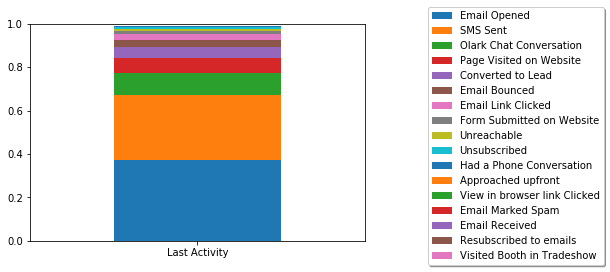

In [1000]:
lastActivity = check_skewness('Last Activity')
#print(df)
ax = plt.subplot(1,1,1)
lastActivity.plot(kind='bar',stacked=True,ax = ax)
plt.xticks(rotation=0)
ax.set_ylim([0.0,1.0])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1.1), shadow=True, ncol=1)

In [1001]:
lastActivity.T

,Last Activity
Email Opened,0.372010
SMS Sent,0.297110
Olark Chat Conversation,0.105314
Page Visited on Website,0.069272
Converted to Lead,0.046325
Email Bounced,0.035177
Email Link Clicked,0.028899
Form Submitted on Website,0.012555
Unreachable,0.010066
Unsubscribed,0.006602


- 37% of rows have `Email Opened` as the value of `Last Activity`
- Replacing 103 missing values of `Last Activity` with `Email Opened`

In [1002]:
lead_data.loc[lead_data['Last Activity'].isnull(),['Last Activity']] = 'Email Opened'
check_skewness('Last Activity').T

,Last Activity
Email Opened,0.383158
SMS Sent,0.297110
Olark Chat Conversation,0.105314
Page Visited on Website,0.069272
Converted to Lead,0.046325
Email Bounced,0.035177
Email Link Clicked,0.028899
Form Submitted on Website,0.012555
Unreachable,0.010066
Unsubscribed,0.006602


In [1003]:
round(100*(lead_data[cat_cols].isnull().sum()/len(lead_data.index)), 2)

Lead Origin                            0.00
Lead Source                            0.00
Last Activity                          0.00
Country                               26.63
Specialization                        15.56
How did you hear about X Education    23.89
Occupation                            29.12
Tags                                  36.28
Lead Profile                          29.32
City                                  15.37
Free copy required                     0.00
Last Notable Activity                  0.00
dtype: float64

#### Handling Country

In [1004]:
check_skewness('Country').T

,Country
India,0.702673
United States,0.007468
United Arab Emirates,0.005737
Singapore,0.002598
Saudi Arabia,0.002273
United Kingdom,0.001624
Australia,0.001407
Qatar,0.001082
Bahrain,0.000758
Hong Kong,0.000758


In [1005]:
print('Missing country values: {}'.format(lead_data['Country'].isnull().sum()))
print('Rows where country and city both are missing: {}'.format(len(lead_data.loc[(lead_data['Country'].isnull() & lead_data['City'].isnull())])))

Missing country values: 2460
Rows where country and city both are missing: 838


In [1006]:
check_count_conversion_rate('Country')

,Country,Counts,Total%,Converted
0,India,6492,0.702673,0.369840
1,United States,69,0.007468,0.260870
2,United Arab Emirates,53,0.005737,0.377358
3,Singapore,24,0.002598,0.458333
4,Saudi Arabia,21,0.002273,0.190476
5,United Kingdom,15,0.001624,0.333333
6,Australia,13,0.001407,0.230769
7,Qatar,10,0.001082,0.100000
8,Bahrain,7,0.000758,0.571429
9,Hong Kong,7,0.000758,0.571429


#### Country seems to be an important columns as Countries like India, US, Singapore have greater than 30% conversion rate.

In [1007]:
check_count_conversion_rate('City')

,City,Counts,Total%,Converted
0,Mumbai,3222,0.348739,0.406269
1,Select,2249,0.243425,0.490440
2,Thane & Outskirts,752,0.081394,0.449468
3,Other Cities,686,0.074250,0.402332
4,Other Cities of Maharashtra,457,0.049464,0.439825
5,Other Metro Cities,379,0.041022,0.406332
6,Tier II Cities,74,0.008010,0.337838


Replacing missing value of `Country` with 'Unknown' where `City` value is also missing 

In [1008]:
lead_data.loc[(lead_data['Country'].isnull() & lead_data['City'].isnull()),['Country']] = 'unknown'

In [1009]:
len(lead_data.loc[(lead_data['Country'].isnull() & lead_data['City'].isnull())])

0

In [1010]:
def handle_country(x):
    if x['City'] in ['Mumbai' ,'Thane & Outskirts','Other Cities of Maharashtra']:
        return 'India'
    else:
        return 'unknown'
    
lead_data.loc[lead_data['Country'].isnull(),['Country']] = lead_data.loc[lead_data['Country'].isnull(),['Country','City']].apply(lambda x: handle_country(x),axis=1)

In [1011]:
check_count_conversion_rate('Country')

,Country,Counts,Total%,Converted
0,India,6826,0.738825,0.389393
1,unknown,2131,0.230653,0.384327
2,United States,69,0.007468,0.260870
3,United Arab Emirates,53,0.005737,0.377358
4,Singapore,24,0.002598,0.458333
5,Saudi Arabia,21,0.002273,0.190476
6,United Kingdom,15,0.001624,0.333333
7,Australia,13,0.001407,0.230769
8,Qatar,10,0.001082,0.100000
9,Bahrain,7,0.000758,0.571429


Unkown also comes in missing value

#### out of 2461 missing value of Country 2131 countries are still unknown and rest are substituted with 'India' as the city column for these have Indian references

In [1012]:
round(100*(lead_data[cat_cols].isnull().sum()/len(lead_data.index)), 2)

Lead Origin                            0.00
Lead Source                            0.00
Last Activity                          0.00
Country                                0.00
Specialization                        15.56
How did you hear about X Education    23.89
Occupation                            29.12
Tags                                  36.28
Lead Profile                          29.32
City                                  15.37
Free copy required                     0.00
Last Notable Activity                  0.00
dtype: float64

#### Handling Specialization

In [1013]:
check_count_conversion_rate('Specialization')

,Specialization,Counts,Total%,Converted
0,Select,1942,0.210196,0.421215
1,Finance Management,976,0.105639,0.446721
2,Human Resource Management,848,0.091785,0.457547
3,Marketing Management,838,0.090702,0.486874
4,Operations Management,503,0.054443,0.473161
5,Business Administration,403,0.043619,0.444169
6,IT Projects Management,366,0.039615,0.382514
7,Supply Chain Management,349,0.037775,0.432665
8,"Banking, Investment And Insurance",338,0.036584,0.494083
9,Media and Advertising,203,0.021972,0.418719


In [1014]:
#Value `Select` acts as missing value. First let is replace missing values with Select
lead_data.loc[pd.isnull(lead_data['Specialization']),['Specialization']] = 'Select'
check_count_conversion_rate('Specialization') .sort_values(by='Total%',ascending=False)           

,Specialization,Counts,Total%,Converted
0,Select,3380,0.365840,0.286686
1,Finance Management,976,0.105639,0.446721
2,Human Resource Management,848,0.091785,0.457547
3,Marketing Management,838,0.090702,0.486874
4,Operations Management,503,0.054443,0.473161
5,Business Administration,403,0.043619,0.444169
6,IT Projects Management,366,0.039615,0.382514
7,Supply Chain Management,349,0.037775,0.432665
8,"Banking, Investment And Insurance",338,0.036584,0.494083
10,Travel and Tourism,203,0.021972,0.354680


#### From above table we can see that Actual missing % of Specialization = 36.58

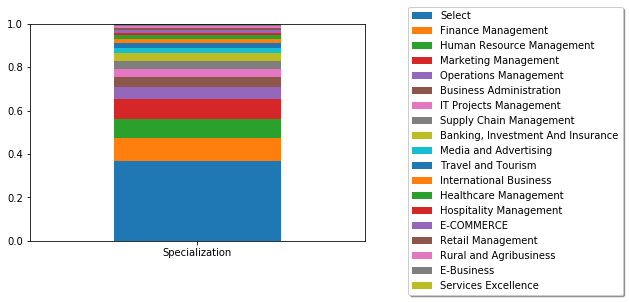

In [1015]:
lastActivity = check_skewness('Specialization')
#print(df)
ax = plt.subplot(1,1,1)
lastActivity.plot(kind='bar',stacked=True,ax = ax)
plt.xticks(rotation=0)
ax.set_ylim([0.0,1.0])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1.1), shadow=True, ncol=1)

#### The maximum % is still missing with value as (Select). As the percentage is large will replace these missing value with `others`

In [1016]:
#### replacing select with Others

lead_data.loc[lead_data['Specialization']=='Select','Specialization']='Others'
check_skewness('Specialization').T

,Specialization
Others,0.365840
Finance Management,0.105639
Human Resource Management,0.091785
Marketing Management,0.090702
Operations Management,0.054443
Business Administration,0.043619
IT Projects Management,0.039615
Supply Chain Management,0.037775
"Banking, Investment And Insurance",0.036584
Media and Advertising,0.021972


#### Handling `How did you hear about X Education`

In [1017]:
check_count_conversion_rate('How did you hear about X Education')

,How did you hear about X Education,Counts,Total%,Converted
0,Select,5043,0.545838,0.482054
1,Online Search,808,0.087455,0.424505
2,Word Of Mouth,348,0.037666,0.436782
3,Student of SomeSchool,310,0.033553,0.461290
4,Other,186,0.020132,0.403226
5,Multiple Sources,152,0.016452,0.368421
6,Advertisements,70,0.007577,0.457143
7,Social Media,66,0.007144,0.409091
8,Email,26,0.002814,0.500000
9,SMS,23,0.002489,0.217391


In [1018]:
lead_data.loc[pd.isnull(lead_data['How did you hear about X Education']),['How did you hear about X Education']] = 'Select'
check_count_conversion_rate('How did you hear about X Education') .sort_values(by='Total%',ascending=False)    

,How did you hear about X Education,Counts,Total%,Converted
0,Select,7250,0.784717,0.374345
1,Online Search,808,0.087455,0.424505
2,Word Of Mouth,348,0.037666,0.436782
3,Student of SomeSchool,310,0.033553,0.461290
4,Other,186,0.020132,0.403226
5,Multiple Sources,152,0.016452,0.368421
6,Advertisements,70,0.007577,0.457143
7,Social Media,66,0.007144,0.409091
8,Email,26,0.002814,0.500000
9,SMS,23,0.002489,0.217391


#### 78% of values for `How did you hear about X Education` is missing. Therefore deleting this column.

In [1019]:
lead_data.drop(['How did you hear about X Education'],axis=1,inplace=True)
print(lead_data.shape)

cat_cols.remove('How did you hear about X Education')
cat_cols

(9239, 17)


['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Country',
 'Specialization',
 'Occupation',
 'Tags',
 'Lead Profile',
 'City',
 'Free copy required',
 'Last Notable Activity']

In [1020]:
round(100*(lead_data[cat_cols].isnull().sum()/len(lead_data.index)), 2)


Lead Origin               0.00
Lead Source               0.00
Last Activity             0.00
Country                   0.00
Specialization            0.00
Occupation               29.12
Tags                     36.28
Lead Profile             29.32
City                     15.37
Free copy required        0.00
Last Notable Activity     0.00
dtype: float64

#### Handling Occupation               

In [1021]:
lead_data['Occupation'].isnull().sum()

2690

In [1022]:
check_count_conversion_rate('Occupation') .sort_values(by='Total%',ascending=False)

,Occupation,Counts,Total%,Converted
0,Unemployed,5599,0.606018,0.435792
1,Working Professional,706,0.076415,0.916431
2,Student,210,0.022730,0.371429
3,Other,16,0.001732,0.625000
4,Housewife,10,0.001082,1.000000
5,Businessman,8,0.000866,0.625000


#### Inferences:
- 60% of leads are Unemployed and they have good conversion rate of 43%
- Though number of working professional is less, but their conversion rate is higher at 91%
- The missing percentage is 29%. Replacing with mode might skew the data.
- Therefore, Replacing null values in Occupation with value `Other`

In [1023]:
lead_data.loc[pd.isnull(lead_data['Occupation']),['Occupation']] = 'Other'
check_count_conversion_rate('Occupation') .sort_values(by='Total%',ascending=False)

,Occupation,Counts,Total%,Converted
0,Unemployed,5599,0.606018,0.435792
1,Other,2706,0.292889,0.140429
2,Working Professional,706,0.076415,0.916431
3,Student,210,0.022730,0.371429
4,Housewife,10,0.001082,1.000000
5,Businessman,8,0.000866,0.625000


#### Handling Tags                     

In [1024]:
lead_data['Tags'].isnull().sum()

3352

In [1025]:
check_count_conversion_rate('Tags').sort_values(by='Total%',ascending=False)

,Tags,Counts,Total%,Converted
0,Will revert after reading the email,2072,0.224267,0.968629
1,Ringing,1203,0.130209,0.028263
2,Interested in other courses,513,0.055525,0.025341
3,Already a student,465,0.050330,0.006452
4,Closed by Horizzon,358,0.038749,0.994413
5,switched off,240,0.025977,0.016667
6,Busy,186,0.020132,0.564516
7,Lost to EINS,175,0.018941,0.977143
8,Not doing further education,145,0.015694,0.006897
9,Interested in full time MBA,117,0.012664,0.025641


In [1026]:
lead_data.loc[pd.isnull(lead_data['Tags']),['Tags']] = 'Others'
check_count_conversion_rate('Tags') .sort_values(by='Total%',ascending=False)

,Tags,Counts,Total%,Converted
0,Others,3352,0.362810,0.249105
1,Will revert after reading the email,2072,0.224267,0.968629
2,Ringing,1203,0.130209,0.028263
3,Interested in other courses,513,0.055525,0.025341
4,Already a student,465,0.050330,0.006452
5,Closed by Horizzon,358,0.038749,0.994413
6,switched off,240,0.025977,0.016667
7,Busy,186,0.020132,0.564516
8,Lost to EINS,175,0.018941,0.977143
9,Not doing further education,145,0.015694,0.006897


In [1027]:
#exp=check_count_conversion_rate('Tags') .sort_values(by='Total%',ascending=False)
#exp.to_csv('analysis.csv')

#### Handling Lead Profile 

In [1028]:
lead_data['Lead Profile'].isnull().sum()

2709

In [1029]:
check_count_conversion_rate('Lead Profile') .sort_values(by='Total%',ascending=False)

,Lead Profile,Counts,Total%,Converted
0,Select,4145,0.448642,0.407961
1,Potential Lead,1613,0.174586,0.785493
2,Other Leads,487,0.052711,0.369610
3,Student of SomeSchool,241,0.026085,0.037344
4,Lateral Student,24,0.002598,0.958333
5,Dual Specialization Student,20,0.002165,1.000000


In [1030]:
#replacing nans with select to get total missing percentage
lead_data.loc[pd.isnull(lead_data['Lead Profile']),['Lead Profile']] = 'Select'
check_count_conversion_rate('Lead Profile') .sort_values(by='Total%',ascending=False)

,Lead Profile,Counts,Total%,Converted
0,Select,6854,0.741855,0.300700
1,Potential Lead,1613,0.174586,0.785493
2,Other Leads,487,0.052711,0.369610
3,Student of SomeSchool,241,0.026085,0.037344
4,Lateral Student,24,0.002598,0.958333
5,Dual Specialization Student,20,0.002165,1.000000


#### 74% of the data is missing for column `Lead Profile`, therefore, deleting the column

In [1031]:
lead_data.drop(['Lead Profile'],axis=1,inplace=True)
print(lead_data.shape)

cat_cols.remove('Lead Profile')
cat_cols

(9239, 16)


['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Country',
 'Specialization',
 'Occupation',
 'Tags',
 'City',
 'Free copy required',
 'Last Notable Activity']

#### Handling City                      

In [1032]:
lead_data['City'].isnull().sum()

1420

In [1033]:
check_count_conversion_rate('City') .sort_values(by='Total%',ascending=False)

,City,Counts,Total%,Converted
0,Mumbai,3222,0.348739,0.406269
1,Select,2249,0.243425,0.490440
2,Thane & Outskirts,752,0.081394,0.449468
3,Other Cities,686,0.074250,0.402332
4,Other Cities of Maharashtra,457,0.049464,0.439825
5,Other Metro Cities,379,0.041022,0.406332
6,Tier II Cities,74,0.008010,0.337838


In [1034]:
#replacing nans with select to get total count
lead_data.loc[pd.isnull(lead_data['City']),['City']] = 'Select'
check_count_conversion_rate('City') .sort_values(by='Total%',ascending=False)

,City,Counts,Total%,Converted
0,Select,3669,0.397121,0.342600
1,Mumbai,3222,0.348739,0.406269
2,Thane & Outskirts,752,0.081394,0.449468
3,Other Cities,686,0.074250,0.402332
4,Other Cities of Maharashtra,457,0.049464,0.439825
5,Other Metro Cities,379,0.041022,0.406332
6,Tier II Cities,74,0.008010,0.337838


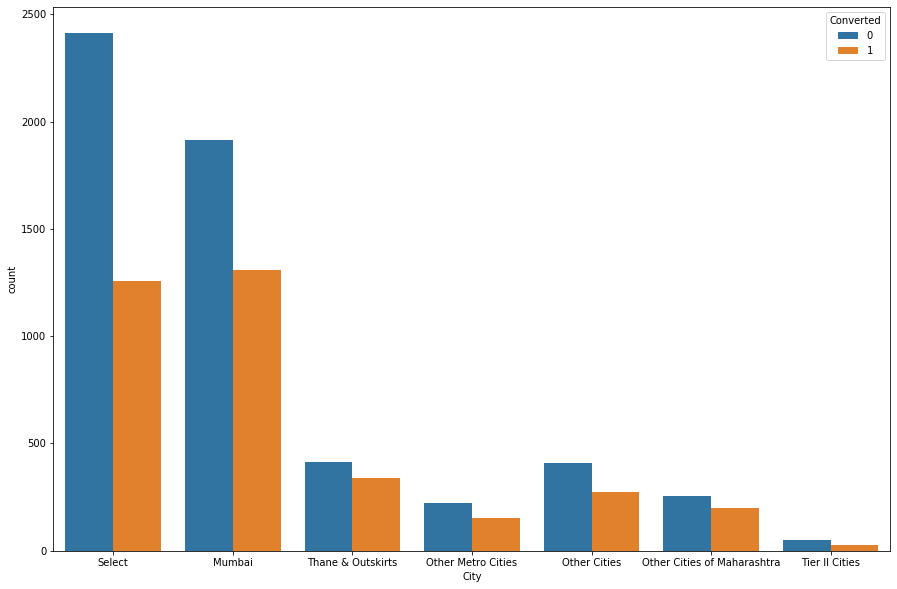

In [1035]:
plt.figure(figsize=(15,10))
sns.countplot(x='City',hue='Converted',data=lead_data)

#### Inference
- Close to 40% of the values are missing
- Each value have equal probaility of conversion(~40%), which might not help in prediction
- As city column is not adding value, deleting the column

In [1036]:
lead_data.drop(['City'],axis=1,inplace=True)
print(lead_data.shape)

cat_cols.remove('City')
cat_cols

(9239, 15)


['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Country',
 'Specialization',
 'Occupation',
 'Tags',
 'Free copy required',
 'Last Notable Activity']

In [1037]:
round(100*(lead_data[cat_cols].isnull().sum()/len(lead_data.index)), 2)


Lead Origin              0.0
Lead Source              0.0
Last Activity            0.0
Country                  0.0
Specialization           0.0
Occupation               0.0
Tags                     0.0
Free copy required       0.0
Last Notable Activity    0.0
dtype: float64

In [1038]:
lead_data.shape

(9239, 15)

#### Till now 
- only 1 row deleted
- 20 columns deleted(14 skewed, 5 missing >45, 1 based on data)

#### 2.3 Cleaning and Visualizing numerical variables<a id='step2.3'></a>

In [1039]:
lead_data['TotalVisits'].isnull().sum()

136

In [1040]:
num_cols = ['TotalVisits','Website Time','Page Views Per Visit']
num_cols

['TotalVisits', 'Website Time', 'Page Views Per Visit']

#### Total Visits 

In [1041]:
### Visualising Total visits data 
lead_data['TotalVisits'].value_counts()
#lead_data['TotalVisits'].describe()

0.0      2189
2.0      1680
3.0      1306
4.0      1120
5.0       783
6.0       466
1.0       395
7.0       309
8.0       224
9.0       164
10.0      114
11.0       86
13.0       48
12.0       45
14.0       36
16.0       21
15.0       18
17.0       16
18.0       15
20.0       12
19.0        9
23.0        6
21.0        6
27.0        5
24.0        5
25.0        5
22.0        3
28.0        2
29.0        2
26.0        2
251.0       1
74.0        1
30.0        1
141.0       1
54.0        1
41.0        1
115.0       1
43.0        1
42.0        1
32.0        1
55.0        1
Name: TotalVisits, dtype: int64

In [1042]:
### Analysing Total visits data 
lead_data['TotalVisits'].median() ##3.0
lead_data['TotalVisits'].mean() ##3.45
## Since the Total visits cannot be fractional,replacing with 3 considering both mean and median values
lead_data.loc[pd.isnull(lead_data['TotalVisits']),'TotalVisits']=lead_data['TotalVisits'].median()

In [1043]:
lead_data['TotalVisits'].isnull().sum()

0

#### Page Views Per Visit

In [1044]:
lead_data['Page Views Per Visit'].isnull().sum()

136

In [1045]:
lead_data['Page Views Per Visit'].value_counts()

0.00    2189
2.00    1795
3.00    1196
4.00     896
1.00     651
        ... 
1.27       1
8.21       1
2.14       1
2.63       1
2.45       1
Name: Page Views Per Visit, Length: 114, dtype: int64

In [1046]:
## Analysing Page views per visit data
lead_data['Page Views Per Visit'].median() ## 2.0
lead_data['Page Views Per Visit'].mean() ## 2.36
lead_data.loc[pd.isnull(lead_data['TotalVisits']),'TotalVisits']=lead_data['TotalVisits'].median()
lead_data.loc[pd.isnull(lead_data['Page Views Per Visit']),'Page Views Per Visit']=lead_data['Page Views Per Visit'].median()

In [1047]:
lead_data['Page Views Per Visit'].isnull().sum()

0

In [1048]:
lead_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9239 entries, 0 to 9239
Data columns (total 15 columns):
Prospect ID              9239 non-null object
Lead Number              9239 non-null int64
Lead Origin              9239 non-null object
Lead Source              9239 non-null object
Converted                9239 non-null int64
TotalVisits              9239 non-null float64
Website Time             9239 non-null int64
Page Views Per Visit     9239 non-null float64
Last Activity            9239 non-null object
Country                  9239 non-null object
Specialization           9239 non-null object
Occupation               9239 non-null object
Tags                     9239 non-null object
Free copy required       9239 non-null object
Last Notable Activity    9239 non-null object
dtypes: float64(2), int64(3), object(10)
memory usage: 1.4+ MB


#### 2.4 Outlier Treatment<a id='step2.4'></a>

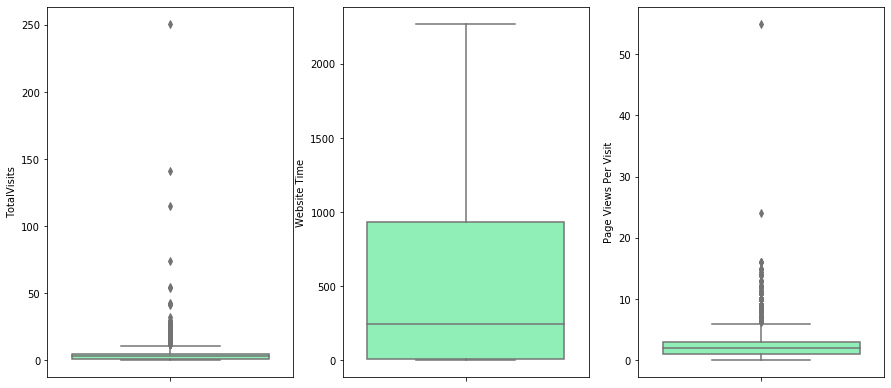

In [1049]:
plt.figure(figsize=(15,15))
for col in num_cols:
    plt.subplot(2,3,num_cols.index(col)+1)
    sns.boxplot(y=col,data=lead_data,palette='rainbow')

#### Observation:
Total Visits and Page views per visit have Outliers

In [1050]:
lead_data[['TotalVisits','Page Views Per Visit']].describe(percentiles=(0.95,0.99))

,TotalVisits,Page Views Per Visit
count,9239.000000,9239.000000
mean,3.438684,2.357479
std,4.819282,2.145894
min,0.000000,0.000000
50%,3.000000,2.000000
95%,10.000000,6.000000
99%,17.000000,9.000000
max,251.000000,55.000000


In [1051]:
lead_data['TotalVisits'].value_counts(ascending=False)

## capping at 99% value - 17

lead_data.loc[lead_data['TotalVisits']>17,['TotalVisits']]=17

In [1052]:
lead_data['TotalVisits'].value_counts(ascending=False)

0.0     2189
2.0     1680
3.0     1442
4.0     1120
5.0      783
6.0      466
1.0      395
7.0      309
8.0      224
9.0      164
10.0     114
17.0      99
11.0      86
13.0      48
12.0      45
14.0      36
16.0      21
15.0      18
Name: TotalVisits, dtype: int64

In [1053]:
## Capping at 99% value - 9

lead_data.loc[lead_data['Page Views Per Visit']>9,'Page Views Per Visit']=9
lead_data['Page Views Per Visit'].value_counts()

0.00    2189
2.00    1931
3.00    1196
4.00     896
1.00     651
        ... 
2.38       1
8.50       1
1.31       1
3.43       1
1.64       1
Name: Page Views Per Visit, Length: 102, dtype: int64

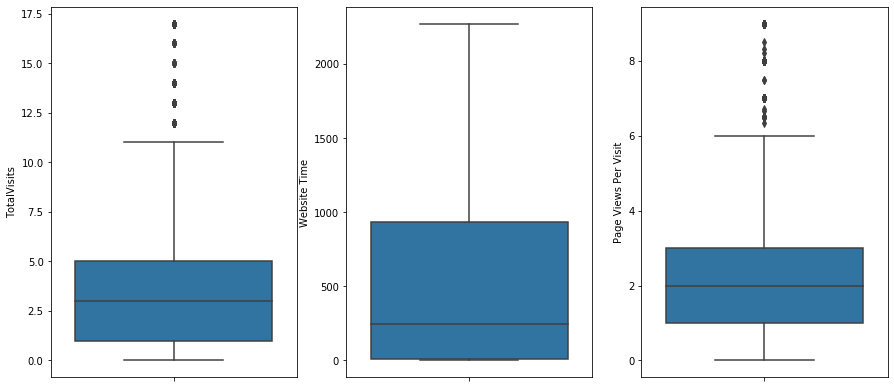

In [1054]:
## Replotting the box plots

plt.figure(figsize=(15,15))
for col in num_cols:
    plt.subplot(2,3,num_cols.index(col)+1)
    sns.boxplot(y=col,data=lead_data)


#### 2.5 Check for duplicates<a id='step2.5'></a>

#### 2.6 Check for data type conversion<a id='step2.6'></a>

In [1055]:
lead_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9239 entries, 0 to 9239
Data columns (total 15 columns):
Prospect ID              9239 non-null object
Lead Number              9239 non-null int64
Lead Origin              9239 non-null object
Lead Source              9239 non-null object
Converted                9239 non-null int64
TotalVisits              9239 non-null float64
Website Time             9239 non-null int64
Page Views Per Visit     9239 non-null float64
Last Activity            9239 non-null object
Country                  9239 non-null object
Specialization           9239 non-null object
Occupation               9239 non-null object
Tags                     9239 non-null object
Free copy required       9239 non-null object
Last Notable Activity    9239 non-null object
dtypes: float64(2), int64(3), object(10)
memory usage: 1.4+ MB


#### Observation : 
No datatype conversion required

## Step 3. Preprocessing and Data Preparation<a id='step3'></a>

#### 3.1 Categorizing variables<a id='step3.1'></a>

In [1056]:
#Lead source grouping into others category
values=lead_data['Lead Source'].value_counts()
#type(values)
val=values[values.lt(7)].index
#val
lead_data.loc[lead_data['Lead Source'].isin(val),'Lead Source']='Others'
lead_data['Lead Source'].value_counts()

Google              2873
Direct Traffic      2544
Olark Chat          1755
Organic Search      1154
Reference            567
Welingak Website     142
Referral Sites       125
Facebook              55
Others                24
Name: Lead Source, dtype: int64

In [1057]:
#country categorization
check_count_conversion_rate('Country')

,Country,Counts,Total%,Converted
0,India,6826,0.738825,0.389393
1,unknown,2131,0.230653,0.384327
2,United States,69,0.007468,0.260870
3,United Arab Emirates,53,0.005737,0.377358
4,Singapore,24,0.002598,0.458333
5,Saudi Arabia,21,0.002273,0.190476
6,United Kingdom,15,0.001624,0.333333
7,Australia,13,0.001407,0.230769
8,Qatar,10,0.001082,0.100000
9,Bahrain,7,0.000758,0.571429


There are 37 different countries and many have very few data. Clubbing them together based on the continents.

In [1058]:
asia=['Singapore',
'Saudi Arabia',
'Qatar',
'Bahrain', 
'Hong Kong', 
'Oman', 
'Kuwait',
'Philippines', 
'Bangladesh', 
'Asia/Pacific Region',
'China', 
'Malaysia',  
'Russia',
'Vietnam',
'Indonesia',
'Sri Lanka',
'United Arab Emirates']

africa= ['Kenya',
'South Africa',
'Nigeria',
'Uganda',
'Ghana',
'Tanzania',
'Liberia']

europe = ['United Kingdom',
'France',
'Germany',
'Sweden',
'Netherlands',
'Belgium',
'Italy',
'Switzerland',
'Denmark']

north_america = ['United States','Canada']

def categorize_country(x):
    if x in asia:
        return 'Asia'
    elif x in africa:
        return 'Africa'
    elif x in europe:
        return 'Europe'
    elif x in north_america:
        return 'North_america'
    else:
        return x

lead_data['country_categorized'] = lead_data['Country'].apply(lambda x: categorize_country(x))

In [1059]:
check_count_conversion_rate('country_categorized')

,country_categorized,Counts,Total%,Converted
0,India,6826,0.738825,0.389393
1,unknown,2131,0.230653,0.384327
2,Asia,145,0.015694,0.337931
3,North_america,73,0.007901,0.246575
4,Europe,36,0.003897,0.333333
5,Africa,15,0.001624,0.066667
6,Australia,13,0.001407,0.230769


In [1060]:
lead_data[['Country','country_categorized']].head(10)

,Country,country_categorized
0,unknown,unknown
1,India,India
2,India,India
3,India,India
4,India,India
5,unknown,unknown
6,India,India
7,unknown,unknown
8,India,India
9,India,India


In [1061]:
lead_data['Country'] = lead_data['country_categorized']
lead_data['Country'].value_counts()

India            6826
unknown          2131
Asia              145
North_america      73
Europe             36
Africa             15
Australia          13
Name: Country, dtype: int64

In [1062]:
#Tags categorization
check_count_conversion_rate('Tags')

,Tags,Counts,Total%,Converted
0,Others,3352,0.362810,0.249105
1,Will revert after reading the email,2072,0.224267,0.968629
2,Ringing,1203,0.130209,0.028263
3,Interested in other courses,513,0.055525,0.025341
4,Already a student,465,0.050330,0.006452
5,Closed by Horizzon,358,0.038749,0.994413
6,switched off,240,0.025977,0.016667
7,Busy,186,0.020132,0.564516
8,Lost to EINS,175,0.018941,0.977143
9,Not doing further education,145,0.015694,0.006897


There are 27 different values of Tags. We will be bucketing them into following categories based upon the business knowledge

- Interested
- Busy
- Probable
- Lost


In [1063]:
interested = ['Will revert after reading the email','Interested in other courses',
              'Closed by Horizzon',
              'Want to take admission but has financial problems',
              'Still Thinking',  
              'In confusion whether part time or DLP',
              'Interested in Next batch',
              'Shall take in the next coming month',
              'University not recognized']
lost = ['Lost to EINS','invalid number',
        'Diploma holder (Not Eligible)',
        'number not provided',
        'wrong number given',
        'Lost to Others',
        'Already a student']
busy = ['Busy',
        'opp hangup']
probable = ['Not doing further education',
            'Interested  in full time MBA',
            'Graduation in progress',
            'in touch with EINS','Lateral student',
           'Recognition issue (DEC approval)']
def categorize_tags(x):
    if x in interested:
        return 'interested'
    elif x in lost:
        return 'lost'
    elif x in busy:
        return 'busy'
    elif x in probable:
        return 'probable'
    else:
        return x

lead_data['tags_categorized'] = lead_data['Tags'].apply(lambda x: categorize_tags(x))

In [1064]:
lead_data['tags_categorized'].value_counts()

Others          3352
interested      2969
Ringing         1203
lost             867
probable         389
switched off     240
busy             219
Name: tags_categorized, dtype: int64

In [1065]:
lead_data[['Tags','tags_categorized']].head(10)

,Tags,tags_categorized
0,Interested in other courses,interested
1,Ringing,Ringing
2,Will revert after reading the email,interested
3,Ringing,Ringing
4,Will revert after reading the email,interested
5,Others,Others
6,Will revert after reading the email,interested
7,Others,Others
8,Others,Others
9,Others,Others


In [1066]:
lead_data['Tags'] = lead_data['tags_categorized']
lead_data['Tags'].value_counts()

Others          3352
interested      2969
Ringing         1203
lost             867
probable         389
switched off     240
busy             219
Name: Tags, dtype: int64

In [1067]:
lead_data.drop(['tags_categorized','country_categorized'],axis=1,inplace=True)
lead_data.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source', 'Converted',
       'TotalVisits', 'Website Time', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'Occupation', 'Tags', 'Free copy required',
       'Last Notable Activity'],
      dtype='object')

#### 3.2 Converting Binary Columns <a id='step3.2'></a>

In [1068]:
### Creating dummies for binary columns with Yes/No values
binary_cols=['Free copy required']
binary_cols

['Free copy required']

In [1069]:
for col in binary_cols:
    lead_data[col]=lead_data[col].map({'Yes':1,'No':0})

In [1070]:
#lead_data['Do Not Email'].value_counts()
#print(lead_data['Do Not Call'].value_counts())

In [1071]:
#lead_data['Do Not Call'].value_counts()

In [1072]:
#lead_data['Through Recommendations'].value_counts()

In [1073]:
lead_data['Free copy required'].value_counts()

0    6351
1    2888
Name: Free copy required, dtype: int64

#### 3.3 Creating dummy variables <a id='step3.3' ></a>

In [1074]:
cat_cols.remove('Free copy required')
cols_with_others = ['Lead Source','Tags','Specialization','Country','Occupation']
for col in cat_cols:
    if col not in cols_with_others:
        dummies=pd.get_dummies(lead_data[col],prefix=col,drop_first=True)
        lead_data=pd.concat([lead_data,dummies],axis=1)

### need to check this part below

In [1075]:

### need to check this part below
for col in cols_with_others:
    dummies=pd.get_dummies(lead_data[col],prefix=col)
    lead_data=pd.concat([lead_data,dummies],axis=1)    

lead_data.drop(['Lead Source_Others','Tags_Others','Specialization_Others','Country_unknown','Occupation_Other'],axis=1,inplace=True)

In [1076]:
lead_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9239 entries, 0 to 9239
Data columns (total 92 columns):
Prospect ID                                           9239 non-null object
Lead Number                                           9239 non-null int64
Lead Origin                                           9239 non-null object
Lead Source                                           9239 non-null object
Converted                                             9239 non-null int64
TotalVisits                                           9239 non-null float64
Website Time                                          9239 non-null int64
Page Views Per Visit                                  9239 non-null float64
Last Activity                                         9239 non-null object
Country                                               9239 non-null object
Specialization                                        9239 non-null object
Occupation                                            9239 non-null o

In [1077]:
cat_cols

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Country',
 'Specialization',
 'Occupation',
 'Tags',
 'Last Notable Activity']

#### <font color=Red>Last notable activity is a replica of Last Activity with 3407 rows having values as Modified .Hence,it would be ideal to drop it.The pivot of both available in Excel sheet that i shared</font>

#### Dropping redundant columns - final step of cleaning

In [1078]:
lead_data.drop(cat_cols,inplace=True,axis=1)
lead_data.drop('Prospect ID',inplace=True,axis=1) ## some more to be dropped

In [1079]:
y=lead_data.pop('Converted')
lead_data.columns

Index(['Lead Number', 'TotalVisits', 'Website Time', 'Page Views Per Visit',
       'Free copy required', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Lead Add Form', 'Lead Origin_Lead Import',
       'Last Activity_Converted to Lead', 'Last Activity_Email Bounced',
       'Last Activity_Email Link Clicked', 'Last Activity_Email Marked Spam',
       'Last Activity_Email Opened', 'Last Activity_Email Received',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Page Visited on Website',
       'Last Activity_Resubscribed to emails', 'Last Activity_SMS Sent',
       'Last Activity_Unreachable', 'Last Activity_Unsubscribed',
       'Last Activity_View in browser link Clicked',
       'Last Activity_Visited Booth in Tradeshow',
       'Last Notable Activity_Email Bounced',
       'Last Notable Activity_Email Link Clicked',
       'Last Notable Activity_Email M

#### 3.3 Train test split<a id='step3.3'></a>

In [1080]:
X_train,X_test,y_train,y_test=train_test_split(lead_data,y,train_size=0.7,test_size=0.3,random_state=100)

In [1081]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6467 entries, 5421 to 5641
Data columns (total 82 columns):
Lead Number                                           6467 non-null int64
TotalVisits                                           6467 non-null float64
Website Time                                          6467 non-null int64
Page Views Per Visit                                  6467 non-null float64
Free copy required                                    6467 non-null int64
Lead Origin_Landing Page Submission                   6467 non-null uint8
Lead Origin_Lead Add Form                             6467 non-null uint8
Lead Origin_Lead Import                               6467 non-null uint8
Last Activity_Converted to Lead                       6467 non-null uint8
Last Activity_Email Bounced                           6467 non-null uint8
Last Activity_Email Link Clicked                      6467 non-null uint8
Last Activity_Email Marked Spam                       6467 non-null uint

#### 3.4 Scaling data<a id='step3.4'></a>

In [1082]:
num_cols

['TotalVisits', 'Website Time', 'Page Views Per Visit']

In [1083]:
X_train.shape

(6467, 82)

In [1084]:
scaling=StandardScaler()
X_train[num_cols]=scaling.fit_transform(X_train[num_cols])
X_train.head()

,Lead Number,TotalVisits,Website Time,Page Views Per Visit,Free copy required,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Tags_Ringing,Tags_busy,Tags_interested,Tags_lost,Tags_probable,Tags_switched off,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Country_Africa,Country_Asia,Country_Australia,Country_Europe,Country_India,Country_North_america,Occupation_Businessman,Occupation_Housewife,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional
5421,608309,-0.091536,1.673818,0.350917,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6335,601302,2.087091,2.081309,1.366352,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
6809,597540,0.842161,-0.641968,1.874069,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
7595,591462,-0.402769,1.091688,-0.664518,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7917,589061,-0.402769,1.521009,-0.156800,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [1085]:
X_train.shape

(6467, 82)

### Modelling

In [1086]:
## Running the first time
logm=sm.GLM(y_train,sm.add_constant(X_train),family=sm.families.Binomial())
logm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6467
Model:                            GLM   Df Residuals:                     6388
Model Family:                Binomial   Df Model:                           78
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1736.2
Date:                Thu, 16 Apr 2020   Deviance:                       3472.4
Time:                        23:36:00   Pearson chi2:                 1.17e+04
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                 13.5641   9899.752      0.001      0.999   -1.94e+04    1.94e+04
Lead Number                                         5.608e-06      2e-06      2.805      0.005    1.69e-06    9.53e-06
TotalVisits                                            0.2786      0.064      4.360      0.000       0.153       0.404
Website Time                                           1.0435      0.051     20.337      0.000       0.943       1.144
Page Views Per Visit                                  -0.3032      0.073     -4.178      0.000      -0.445      -0.161
Free copy required                                    -0.1559      0.139     -1.119      0.263      -0.429       0.117
Lead Origin_Landing Page Submission                   -0.4505      0.183     -2.456      0.014      -0.810      -0.091
Lead Origin_Lead Add Form                             -0.1208      0.981     -0.123      0.902      -2.044       1.802
Lead Origin_Lead Import                                0.2775      1.976      0.140      0.888      -3.595       4.150
Last Activity_Converted to Lead                      -21.8359   1.06e+04     -0.002      0.998   -2.09e+04    2.08e+04
Last Activity_Email Bounced                          -23.0294   1.06e+04     -0.002      0.998   -2.09e+04    2.08e+04
Last Activity_Email Link Clicked                     -21.9346   1.06e+04     -0.002      0.998   -2.09e+04    2.08e+04
Last Activity_Email Marked Spam                       -0.0501   1.09e+04  -4.61e-06      1.000   -2.13e+04    2.13e+04
Last Activity_Email Opened                           -20.8380   1.06e+04     -0.002      0.998   -2.09e+04    2.08e+04
Last Activity_Email Received                          -3.2302   3.14e+04     -0.000      1.000   -6.15e+04    6.15e+04
Last Activity_Form Submitted on Website              -21.2847   1.06e+04     -0.002      0.998   -2.09e+04    2.08e+04
Last Activity_Had a Phone Conversation               -17.0183   1.06e+04     -0.002      0.999   -2.09e+04    2.08e+04
Last Activity_Olark Chat Conversation                -22.1784   1.06e+04     -0.002      0.998   -2.09e+04    2.08e+04
Last Activity_Page Visited on Website                -21.4569   1.06e+04     -0.002      0.998   -2.09e+04    2.08e+04
Last Activity_Resubscribed to emails                   3.1643   1.49e+04      0.000      1.000   -2.93e+04    2.93e+04
Last Activity_SMS Sent                               -19.9377   1.06e+04     -0.002      0.999   -2.09e+04    2.08e+04
Last Activity_Unreachable                            -20.7065   1.06e+04     -0.002      0.998   -2.09e+04    2.08e+04
Last Activity_Unsubscribed                           -21.6020   1.06e+04     -0.002      0.998   -2.09e+04  

### Correlation heatmap -- after finalising all columns

### Feature selection using RFE

In [1087]:
log_reg=LogisticRegression()
rfe=RFE(log_reg,15)
rfe=rfe.fit(X_train,y_train)
rfe.ranking_

array([ 1,  6,  1, 19,  2,  1,  1, 36,  8, 10, 17, 59,  3, 58, 23, 32,  1,
        9, 64,  1, 45, 40, 57, 67, 26, 21, 60,  4, 65, 66, 43,  1, 15, 18,
       63,  1, 46, 47, 68,  1, 35, 12,  1, 13,  1, 22, 14,  1, 33,  1,  5,
        7, 11, 27, 56, 51, 37, 24, 42, 49, 31, 30, 38, 20, 41, 29, 53, 62,
       44, 52, 28, 50, 25, 55, 54,  1, 34, 61, 48, 39, 16,  1])

In [1088]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Lead Number', True, 1),
 ('TotalVisits', False, 6),
 ('Website Time', True, 1),
 ('Page Views Per Visit', False, 19),
 ('Free copy required', False, 2),
 ('Lead Origin_Landing Page Submission', True, 1),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 36),
 ('Last Activity_Converted to Lead', False, 8),
 ('Last Activity_Email Bounced', False, 10),
 ('Last Activity_Email Link Clicked', False, 17),
 ('Last Activity_Email Marked Spam', False, 59),
 ('Last Activity_Email Opened', False, 3),
 ('Last Activity_Email Received', False, 58),
 ('Last Activity_Form Submitted on Website', False, 23),
 ('Last Activity_Had a Phone Conversation', False, 32),
 ('Last Activity_Olark Chat Conversation', True, 1),
 ('Last Activity_Page Visited on Website', False, 9),
 ('Last Activity_Resubscribed to emails', False, 64),
 ('Last Activity_SMS Sent', True, 1),
 ('Last Activity_Unreachable', False, 45),
 ('Last Activity_Unsubscribed', False, 40),
 ('Last Activity_View in browse

In [1089]:
def deduce_best_model(y_train,X_train_rfe,drop_column=''):
    
    #X_train_rfe_trials=X_train_rfe
    if drop_column!='':
        X_train_rfe=X_train_rfe.drop(drop_column,axis=1)
    lm=sm.GLM(y_train,X_train_rfe).fit()
    print(lm.summary())
    
    X_train_new=X_train_rfe.drop(['const'],axis=1)
#X_train_new
    print()
    print()
    
    print("-------------------------VIF Results-------------------------")
    vif=pd.DataFrame()
    temp=X_train_new
    vif['Columns']=temp.columns
    vif['VIF']=[variance_inflation_factor(temp.values,i) for i in range(temp.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    print(vif)
    return X_train_rfe,lm
    

In [1090]:
cols=X_train.columns[rfe.support_]

In [1091]:
cols

Index(['Lead Number', 'Website Time', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Lead Add Form', 'Last Activity_Olark Chat Conversation',
       'Last Activity_SMS Sent', 'Last Notable Activity_Modified',
       'Last Notable Activity_SMS Sent', 'Lead Source_Direct Traffic',
       'Lead Source_Olark Chat', 'Lead Source_Reference', 'Tags_Ringing',
       'Tags_interested', 'Country_India', 'Occupation_Working Professional'],
      dtype='object')

In [1092]:
log_reg.fit(X_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [1093]:
X_train_rfe=X_train[cols]
X_train_rfe=sm.add_constant(X_train_rfe)

In [1094]:
X_train_rfe,lm1=deduce_best_model(y_train,X_train_rfe)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6467
Model:                            GLM   Df Residuals:                     6451
Model Family:                Gaussian   Df Model:                           15
Link Function:               identity   Scale:                         0.10364
Method:                          IRLS   Log-Likelihood:                -1838.6
Date:                Thu, 16 Apr 2020   Deviance:                       668.60
Time:                        23:36:02   Pearson chi2:                     669.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [1095]:
X_train_rfe,lm2=deduce_best_model(y_train,X_train_rfe,'Lead Number') ## Dropping 'Lead Number' as it has high VIF.

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6467
Model:                            GLM   Df Residuals:                     6452
Model Family:                Gaussian   Df Model:                           14
Link Function:               identity   Scale:                         0.10387
Method:                          IRLS   Log-Likelihood:                -1846.0
Date:                Thu, 16 Apr 2020   Deviance:                       670.14
Time:                        23:36:03   Pearson chi2:                     670.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [1096]:
X_train_rfe,lm2=deduce_best_model(y_train,X_train_rfe,'Last Notable Activity_SMS Sent') ## Dropping 'Lead Number' as it has high VIF.

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6467
Model:                            GLM   Df Residuals:                     6453
Model Family:                Gaussian   Df Model:                           13
Link Function:               identity   Scale:                         0.10406
Method:                          IRLS   Log-Likelihood:                -1852.5
Date:                Thu, 16 Apr 2020   Deviance:                       671.50
Time:                        23:36:03   Pearson chi2:                     671.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [1097]:
X_train_rfe,lm2=deduce_best_model(y_train,X_train_rfe,'Country_India') ## Dropping 'Lead Number' as it has high VIF.

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6467
Model:                            GLM   Df Residuals:                     6454
Model Family:                Gaussian   Df Model:                           12
Link Function:               identity   Scale:                         0.10411
Method:                          IRLS   Log-Likelihood:                -1854.5
Date:                Thu, 16 Apr 2020   Deviance:                       671.90
Time:                        23:36:03   Pearson chi2:                     672.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [1098]:
X_train_rfe,lm2=deduce_best_model(y_train,X_train_rfe,'Lead Origin_Lead Add Form') ## Dropping 'Lead Number' as it has high VIF.

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6467
Model:                            GLM   Df Residuals:                     6455
Model Family:                Gaussian   Df Model:                           11
Link Function:               identity   Scale:                         0.10970
Method:                          IRLS   Log-Likelihood:                -2024.3
Date:                Thu, 16 Apr 2020   Deviance:                       708.14
Time:                        23:37:16   Pearson chi2:                     708.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------